# Logistic Regression Classifier: Low vs High Proportion
This notebook collects layer/head grad_norm vectors for low and high proportion, then trains a logistic regression classifier to distinguish between them. Ridge regularization strength is selected via cross-validation, and class balancing is applied.

In [26]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [27]:
def collect_vectors(pickle_path, label):
    with open(pickle_path, 'rb') as f:
        results = pickle.load(f)
    df = pd.DataFrame(results)
    df_vproj = df[df['proj_type'] == 'v_proj']
    layers = np.sort(df_vproj['layer'].unique())
    heads = np.sort(df_vproj['head'].unique())
    n_layer = len(layers)
    n_head = len(heads)
    vectors = []
    indices = []
    for data_index in df_vproj['data_index'].unique():
        sub_df = df_vproj[df_vproj['data_index'] == data_index]
        mat = np.full((n_layer, n_head), np.nan)
        for _, row in sub_df.iterrows():
            l_idx = np.where(layers == row['layer'])[0][0]
            h_idx = np.where(heads == row['head'])[0][0]
            mat[l_idx, h_idx] = row['grad_max']
        vectors.append(mat.flatten())
        indices.append(data_index)
    return np.array(vectors), [label]*len(vectors), indices

In [28]:
# Collect vectors for both files
vec_low, label_low, idx_low = collect_vectors('grad_results_lowprop_prefix200_gen100.pkl', 'low')
vec_high, label_high, idx_high = collect_vectors('grad_results_prefix200_gen100.pkl', 'high')
X = np.concatenate([vec_low, vec_high], axis=0)
y = np.array([0]*len(vec_low) + [1]*len(vec_high))  # 0=low, 1=high

In [29]:
print(X.shape)

(3603, 1024)


In [30]:
# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Train logistic regression with ridge regularization (L2), using cross-validation to select C
clf = LogisticRegressionCV(
    cv=5, penalty='l2', solver='lbfgs', scoring='accuracy', class_weight='balanced',
    max_iter=10000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=10000,
                     random_state=42, scoring='accuracy')

In [32]:
# Evaluate
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {acc:.3f}')
print(classification_report(y_val, y_pred, target_names=['low', 'high']))
# Show selected ridge regularization weight (C)
print('Selected regularization strength (C):', clf.C_)
print('Inverse regularization strength (1/C):', 1/clf.C_)

Validation accuracy: 0.988
              precision    recall  f1-score   support

         low       1.00      0.98      0.99       410
        high       0.98      0.99      0.99       311

    accuracy                           0.99       721
   macro avg       0.99      0.99      0.99       721
weighted avg       0.99      0.99      0.99       721

Selected regularization strength (C): [166.81005372]
Inverse regularization strength (1/C): [0.00599484]


# Evaluate Classifier on Heldout Test Set
We will load the heldout test set data, use the trained classifier to make predictions, and plot a confusion matrix.

In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

vec_low, label_low, idx_low = collect_vectors('grad_results_heldout_lowprop_prefix200_gen100.pkl', 'low')
vec_high, label_high, idx_high = collect_vectors('grad_results_heldout_prefix200_gen100.pkl', 'high')
X_test = np.concatenate([vec_low, vec_high], axis=0)
y_test = np.array([0]*len(vec_low) + [1]*len(vec_high))  # 0=low, 1=high

In [34]:
y_pred_test = clf.predict(X_test)

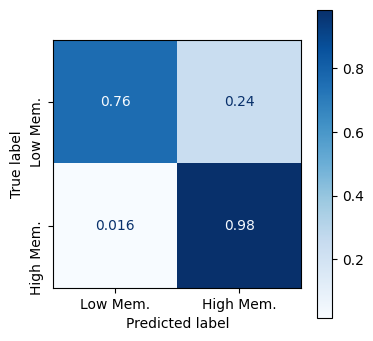

Balanced Accuracy Score: 0.8715


In [35]:
from sklearn.metrics import balanced_accuracy_score

# Define custom class names
class_names = ['Low Mem.', 'High Mem.']

# Plot normalized confusion matrix with custom labels
cm_normalized = confusion_matrix(y_test, y_pred_test, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(4,4))
disp_norm.plot(cmap=plt.cm.Blues, ax=ax)
plt.setp(ax.get_yticklabels(), rotation=90, ha='right')
plt.show()

# Print balanced accuracy score
bal_acc = balanced_accuracy_score(y_test, y_pred_test)
print(f'Balanced Accuracy Score: {bal_acc:.4f}')

In [36]:
np.sum(y_test==0)

2048

In [37]:
np.sum(y_test==1)

123